# Specific Test VI. Foundation Model  

The Task focuses on the classification and enhancement of gravitational lensing images comprising **self-supervised learning, classification, and super-resolution techniques**.  

## Key Components  

1. **Masked Autoencoder (MAE) Pretraining**  
   - A modified MAE model is used for self-supervised pretraining on **no-substructure lensing images**.  
   - Adjustments include syntax fixes, model resizing, and optimized image input handling.  

2. **Masked Autoencoder Classifier**  
   - Converts the MAE into a classification model by **removing the decoder** and replacing it with a classification head.
   - Carries out classification on **axion, CDM and no-substructure lensing images**.  
   - Experiments with different classification strategies led to selecting the **class token approach** for final predictions.  

3. **Super-Resolution Model**

   - A model used for upscaling **Low Res to High Res lensing images**. 
   - A composite model integrating the **MAE encoder**, a **Token-to-Convolution Neck**, and a **Super-Resolution Head**.  
   - The **Token-to-Convolution Neck**, inspired by NASA’s Prithvi EO model, adapts transformer-based embeddings for convolutional processing.  
   - The **Super-Resolution Head** employs **transposed convolutions, resizing, and pixel shuffling** to enhance image resolution while reducing artifacts.  

## Optimization Goals  
- Ensure high-quality **gravitational lensing image reconstruction** with **minimal artifacts**.  
- Optimize models for **high SSIM and PSNR**, ensuring clarity and structural accuracy.  
- Maintain efficiency through **lightweight modifications and optimized architectures**.  


Dependencies

In [1]:
!pip install gdown

In [2]:
!wget https://raw.githubusercontent.com/mishra-18/ML-Models/refs/heads/main/vit.py

--2025-04-01 21:47:17--  https://raw.githubusercontent.com/mishra-18/ML-Models/refs/heads/main/vit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4076 (4.0K) [text/plain]
Saving to: ‘vit.py’

vit.py              100%[===================>]   3.98K  --.-KB/s    in 0s      

2025-04-01 21:47:17 (37.2 MB/s) - ‘vit.py’ saved [4076/4076]



Set up Datasets for MAE Pretraining and Superresolution Training

In [3]:
!gdown --fuzzy https://drive.google.com/file/d/1-5ouNSjatKXW5BTLT2Bffkycd0cxnyOX/view?usp=drive_link
!unzip Dataset1.zip > /dev/null

!gdown --fuzzy https://drive.google.com/file/d/1MGDVMd-igH2SeM423ngxHbX2em799e_f/view?usp=drive_link
!unzip Dataset2.zip > /dev/null

Downloading...
From (original): https://drive.google.com/uc?id=1-5ouNSjatKXW5BTLT2Bffkycd0cxnyOX
From (redirected): https://drive.google.com/uc?id=1-5ouNSjatKXW5BTLT2Bffkycd0cxnyOX&confirm=t&uuid=139e6ad1-d878-44cd-9af7-692a59072907
To: /kaggle/working/Dataset1.zip
100%|██████████████████████████████████████| 2.89G/2.89G [00:37<00:00, 76.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1MGDVMd-igH2SeM423ngxHbX2em799e_f
From (redirected): https://drive.google.com/uc?id=1MGDVMd-igH2SeM423ngxHbX2em799e_f&confirm=t&uuid=4d335904-d170-4045-8fd6-18bf0eb1316c
To: /kaggle/working/Dataset2.zip
100%|████████████████████████████████████████| 533M/533M [00:07<00:00, 71.1MB/s]


Import libraries

In [4]:
import os
import cv2
import time
import math
import torch
import random

import numpy as np
import torch.nn as nn
from tqdm import tqdm 
import torch.optim as optim

import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn.functional as F
from vit import PatchEmbedding, Block
from einops.layers.torch import Rearrange
from sklearn.metrics import roc_curve, auc

import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms.functional as TF
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

In [5]:
# Get the current directory
cwd = os.popen("pwd").read().strip()

In [6]:
# function to carry out min-max normalization

def min_max_normalize(arr):
    min_val = 0.0
    max_val = 4.3
    
    if isinstance(arr, torch.Tensor):
        return (arr - min_val) / (max_val - min_val) if max_val > min_val else torch.zeros_like(arr)
    
    elif isinstance(arr, np.ndarray):
        return (arr - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(arr)
    
    else:
        raise TypeError("Input must be a PyTorch tensor or NumPy array")

Display images in all dataset categories. This is important for visualizing rhe images to make choices on preprocessing, augumentation and model design

Unnormalized High Resolution Dataset Images showing Min, Std and Max


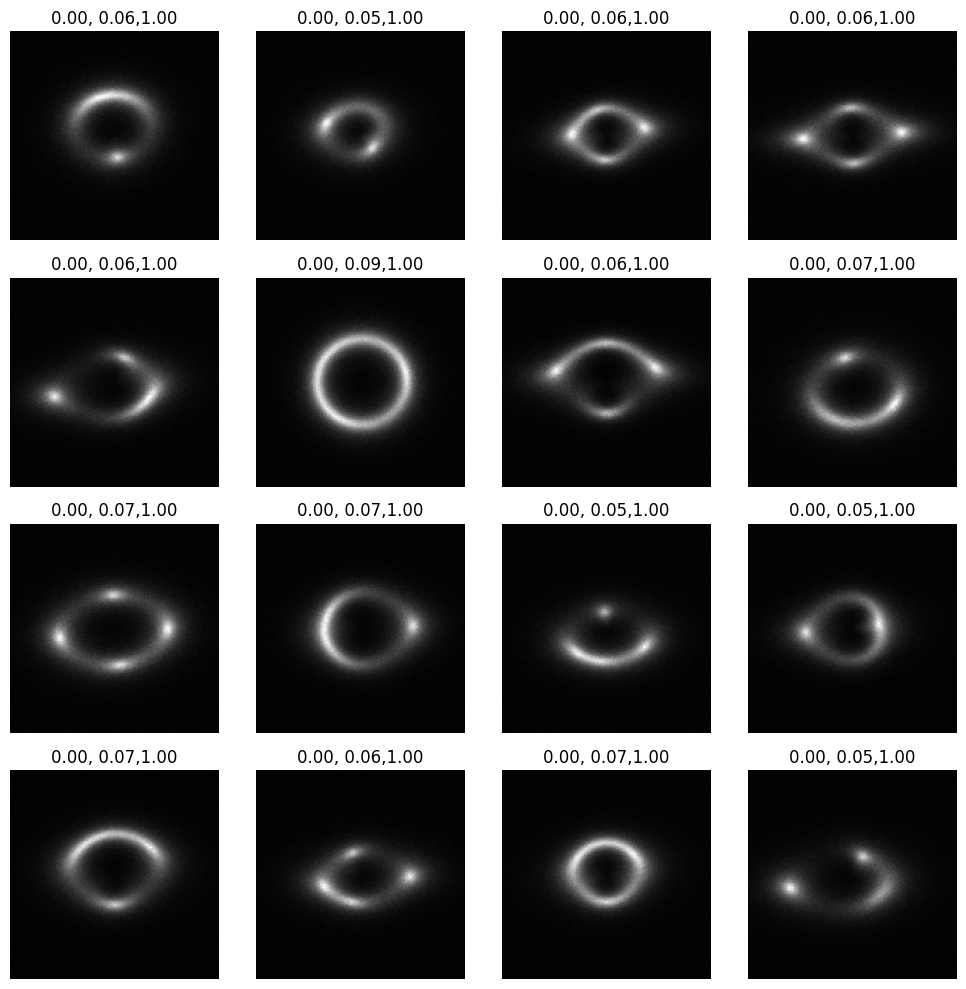

In [7]:
# Path to dataset
dataset_path = f"{cwd}/Dataset/HR"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path, allow_pickle=True)[0]
    #image_data = min_max_normalize(image_data)


    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(f"{image_data.min():.2f}, {image_data.mean():.2f},{image_data.max():.2f}")
    #ax.set_title(os.path.basename(file_path))
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
print("Unnormalized High Resolution Dataset Images showing Min, Std and Max")
plt.show()


Unnormalized Low Resolution Dataset Images showing Min, Std and Max


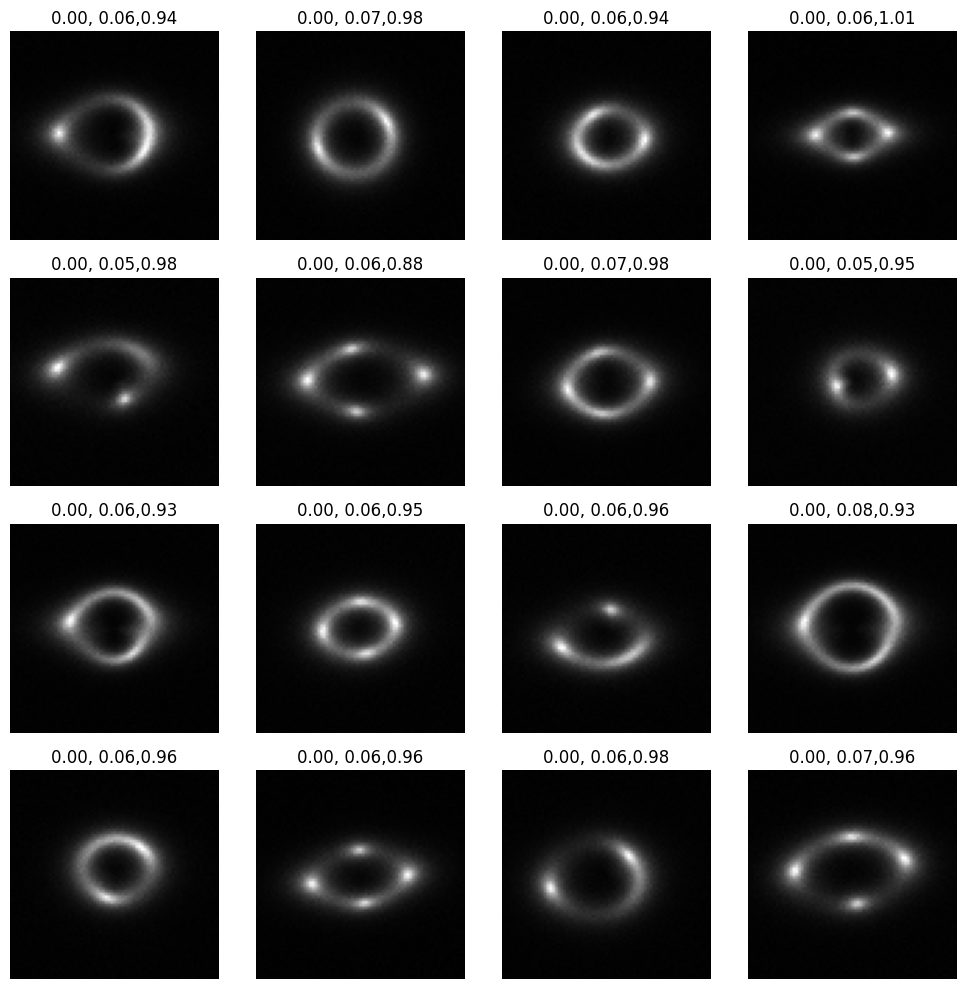

In [8]:
# Path to dataset
dataset_path = f"{cwd}/Dataset/LR"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path, allow_pickle=True)[0]
    #image_data = min_max_normalize(image_data)

    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(f"{image_data.min():.2f}, {image_data.mean():.2f},{image_data.max():.2f}")
    #ax.set_title(os.path.basename(file_path))
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
print("Unnormalized Low Resolution Dataset Images showing Min, Std and Max")
plt.show()


Unnormalized Axion Substructure Dataset Images showing Min, Std and Max


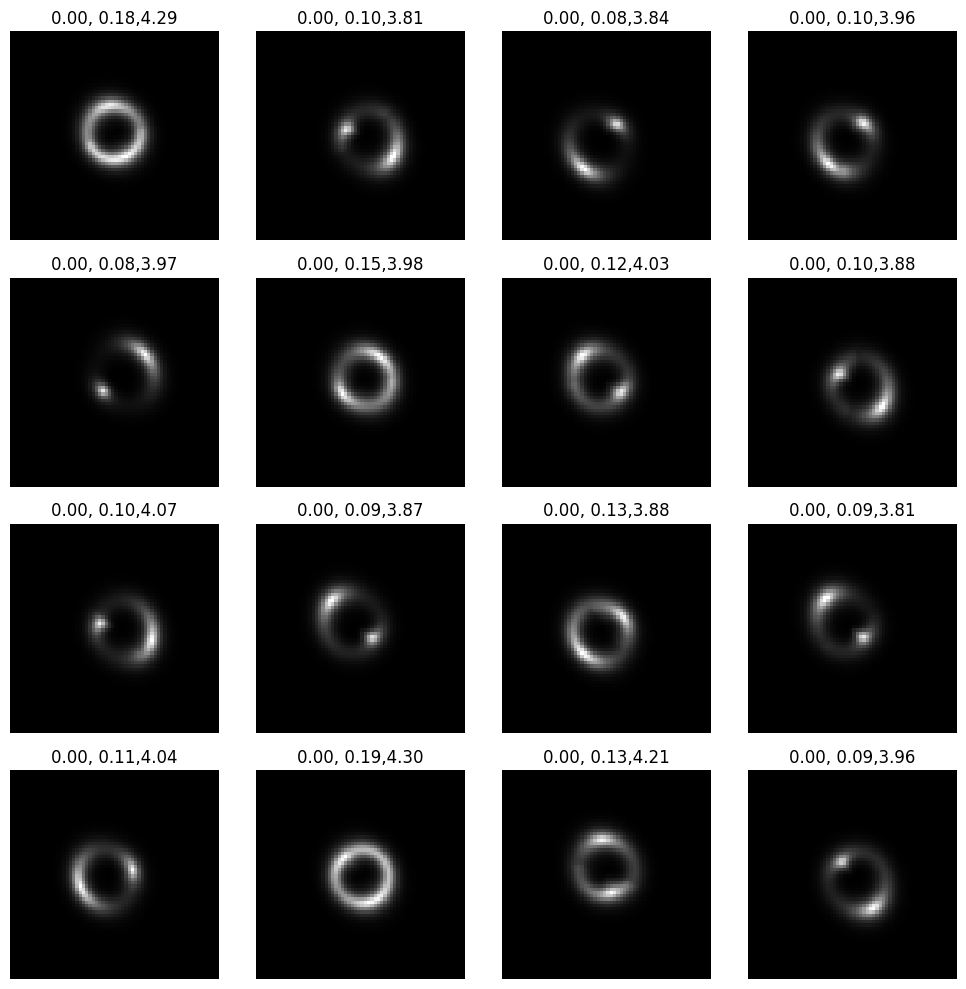

In [9]:
# Path to dataset
dataset_path = f"{cwd}/Dataset/axion"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path, allow_pickle=True)[0]
    #image_data = min_max_normalize(image_data)


    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(f"{image_data.min():.2f}, {image_data.mean():.2f},{image_data.max():.2f}")
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
print("Unnormalized Axion Substructure Dataset Images showing Min, Std and Max")
plt.show()


Unnormalized Cold Dark Matter Substructure Dataset Images showing Min, Std and Max


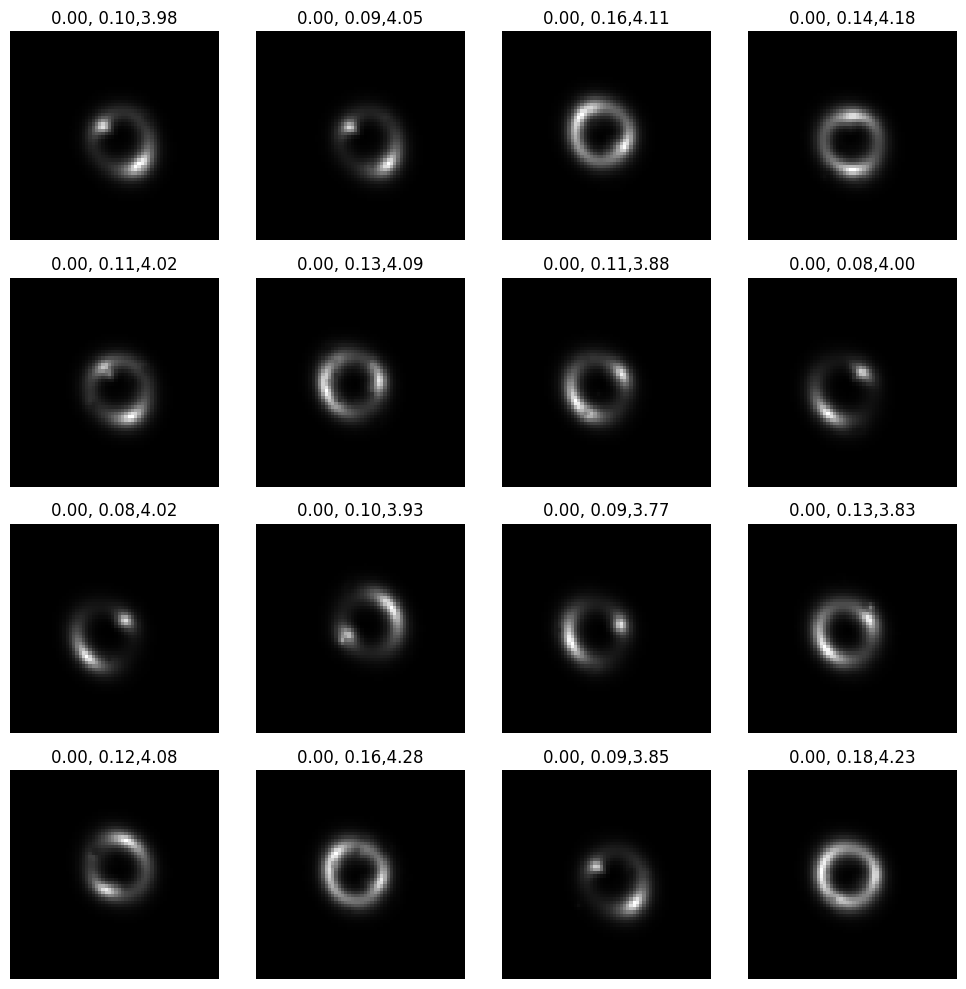

In [10]:
# Path to dataset
dataset_path = f"{cwd}/Dataset/cdm"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path, allow_pickle=True)
    #image_data = min_max_normalize(image_data)


    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(f"{image_data.min():.2f}, {image_data.mean():.2f},{image_data.max():.2f}")
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
print("Unnormalized Cold Dark Matter Substructure Dataset Images showing Min, Std and Max")
plt.show()


Unnormalized No Substructure Dataset Images showing Min, Std and Max


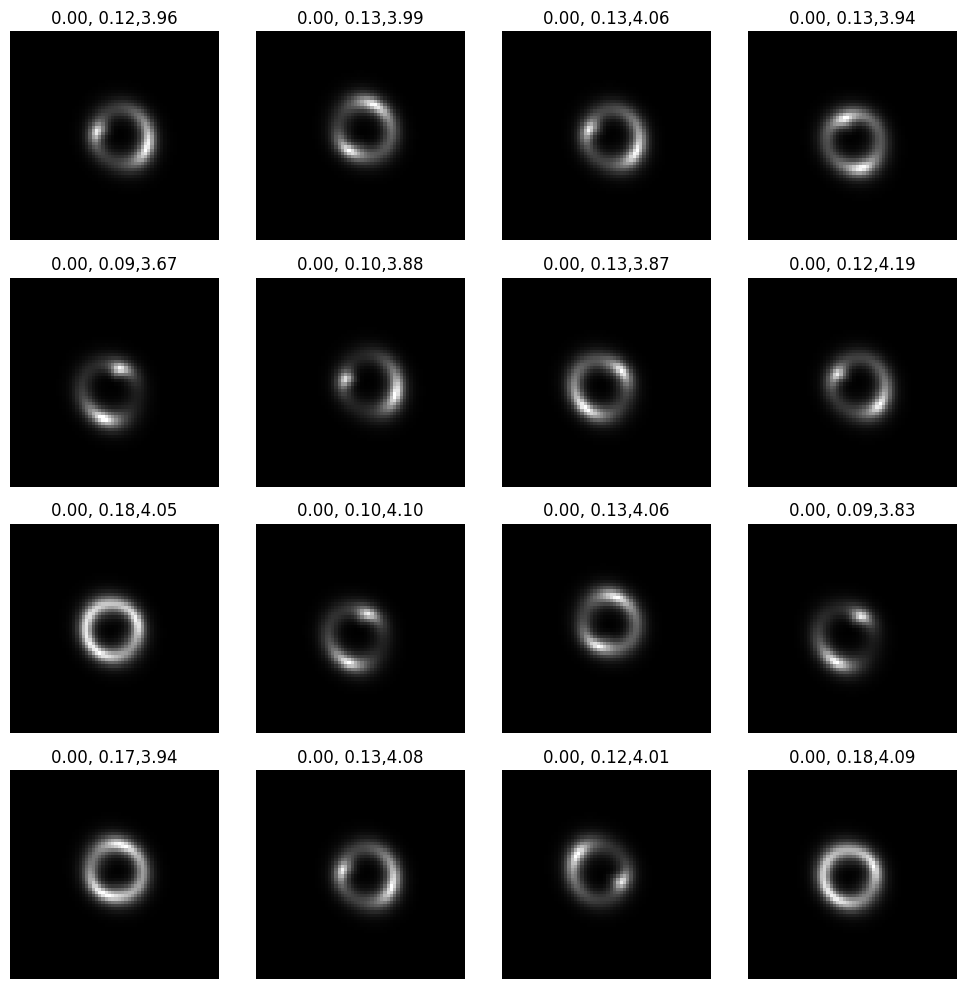

In [11]:
# Path to dataset
dataset_path = f"{cwd}/Dataset/no_sub"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path, allow_pickle=True)
    #image_data = min_max_normalize(image_data)


    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(f"{image_data.min():.2f}, {image_data.mean():.2f},{image_data.max():.2f}")
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
print("Unnormalized No Substructure Dataset Images showing Min, Std and Max")
plt.show()


# Findings from the Datasets  

## 1. Axion Substructure, Cold Dark Matter Substructure, and No Substructure Lensing Images  

- **Data Range:** Values range from 0 to 4.25, with a mean between 0.08 and 0.15.  
- **Structure:** The images exhibit high structural consistency, with minimal variations between classes. Class differences are subtle.  
- **Normalization:** Since these images are used in the super-resolution task, normalization to the range [0,1] is necessary for optimal results.  
- **Augmentation:** The images are position- and rotation-invariant, making vertical and horizontal flips suitable augmentation techniques.  

## 2. Low-Resolution and High-Resolution Lensing Images  

- **Data Range:** Values range from 0 to 1, with a mean between 0.05 and 0.09.  
- **Structure:** Similar to the first dataset, these images are highly structured, with minimal variations between classes. Class differences remain subtle.  
- **Augmentation:** The images are position- and rotation-invariant, making vertical and horizontal flips appropriate for augmentation.  


# Masked Autoencoder (MAE) Model for Pretraining on No-Substructure Lensing Images  

## Overview  

The Masked Autoencoder (MAE) model used for pretraining is a modified version of the implementation by [Shubh Mishra](https://github.com/mishra-18/ML-Models/blob/main/mae.py). This model is based on the Transformer-based MAE framework described in the paper ["Masked Autoencoders Are Scalable Vision Learners"](https://arxiv.org/abs/2111.06377).  

## Modifications and Optimizations  

Several adjustments were made to tailor the model for this specific application:  

1. **Syntax Corrections:** Addressed syntax errors that prevented successful model initialization.  
2. **Model Resizing:** Adjusted the model architecture to create a more compact and efficient solution while maintaining performance.  
3. **Input Size Reduction:** Reduced the image input dimensions to align with the dataset and computational efficiency constraints.  

These modifications ensure that the model is better suited for pretraining on no-substructure lensing images while optimizing resource utilization.  


In [12]:
# MASKED AUTOENCODER MODEL

class MaskedAutoEncoder(nn.Module):
    def __init__(self, emb_size=512, decoder_emb_size=256, patch_size=16, num_head=16, encoder_num_layers=6, decoder_num_layers=4, in_channels=1, img_size=64):
        super().__init__()
        self.patch_embed = PatchEmbedding(emb_size = emb_size, in_channels = in_channels, img_size = img_size, patch_size=patch_size)
        self.decoder_embed = nn.Linear(emb_size, decoder_emb_size)
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, (img_size//patch_size)**2 + 1, decoder_emb_size), requires_grad=False)
        self.decoder_pred = nn.Linear(decoder_emb_size, patch_size**2 * in_channels, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_emb_size))
        self.encoder_transformer = nn.Sequential(*[Block(emb_size, num_head) for _ in range(encoder_num_layers)])
        self.decoder_transformer = nn.Sequential(*[Block(decoder_emb_size, num_head) for _ in range(decoder_num_layers)])
        self.project = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=patch_size**2 * in_channels, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def random_masking(self, x, mask_ratio):
        """
        X: (B T C)
        random masking to create randomly shuffled unmasked patches
        """

        B, T, D = x.shape
        len_keep = int(T * (1 - mask_ratio))

        # creating noise of shape (B, T) to latter generate random indices
        noise = torch.rand(B, T, device=x.device)

        # sorting the noise, and then ids_shuffle to keep the original indexe format
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # gathering the first few samples
        ids_keep = ids_shuffle[:, :len_keep]
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([B, T], device=x.device)
        mask[:, :len_keep] = 0

        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x, mask, ids_restore


    def encoder(self, x, mask_ratio):
        x = self.patch_embed(x)

        cls_token = x[:, :1, :]
        x = x[:, 1:, :]

        x, mask, restore_id = self.random_masking(x, mask_ratio)

        x = torch.cat((cls_token, x), dim=1)

        x = self.encoder_transformer(x)

        return x, mask, restore_id

    def decoder(self, x, restore_id):
        
        #print(x.shape)

        x = self.decoder_embed(x)

        mask_tokens = self.mask_token.repeat(x.shape[0], restore_id.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)
        x_ = torch.gather(x_, dim=1, index=restore_id.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_], dim=1)

        # add pos embed
        x = x + self.decoder_pos_embed

        x = self.decoder_transformer(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, patch*patch*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.project(imgs)

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)

        loss = (loss * mask).sum() / mask.sum()
        return loss

    def forward(self, img):
        mask_ratio = 0.75

        x, mask, restore_ids = self.encoder(img, mask_ratio)
        pred = self.decoder(x, restore_ids)
        loss  = self.loss(img, pred, mask)
        return loss, pred, mask


if __name__ == '__main__':
    # Example usage
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x = torch.rand(1, 1, 64, 64).to(device)
    model = MaskedAutoEncoder().to(device)
    print(model(x)[1].shape)

torch.Size([1, 16, 256])


In [13]:
# Define transformations (without random params)
def mae_transform(img):
    # Apply same random horizontal flip
    if torch.rand(1) < 0.5:
        img = TF.hflip(img)

    # Apply same random vertical flip
    if torch.rand(1) < 0.5:
        img = TF.vflip(img)

    return img

# Define dataset
class MaeDataset(data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.img_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.img_files[idx])
        img = np.load(img_path).astype(np.float32)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        img = min_max_normalize(img)
        

        if self.transform:
            img = self.transform(img)

        return img

In [14]:
# PRETRAINING SETUP

# Warmup function
def get_warmup_cosine_scheduler(optimizer, warmup_epochs, total_epochs, min_lr=1e-5, base_lr=3e-4):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs  # Linear warmup
        return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))

    return LambdaLR(optimizer, lr_lambda)

# Training function
def train(root_dir, epochs=40, batch_size=512, lr=3e-4, warmup_epochs=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    dataset = MaeDataset(root_dir, transform=mae_transform)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)

    model = MaskedAutoEncoder().to(device).train()
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
    scheduler = get_warmup_cosine_scheduler(optimizer, warmup_epochs, epochs)

    for epoch in range(epochs):
        total_loss = 0
        for img in tqdm(dataloader):
            img = img.to(device)
            # Forward pass
            loss, _, _ = model(img)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # Model checkpointing every x epoch
        x = 4
        if (epoch + 1) % x == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch+1}.pt"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

if __name__ == '__main__':
    train(root_dir="Dataset/no_sub")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 58/58 [00:11<00:00,  4.91it/s]


Epoch 1, Loss: 0.057734, LR: 0.000300


100%|██████████| 58/58 [00:11<00:00,  5.03it/s]


Epoch 2, Loss: 0.001640, LR: 0.000300


100%|██████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch 3, Loss: 0.000695, LR: 0.000298


100%|██████████| 58/58 [00:09<00:00,  6.22it/s]


Epoch 4, Loss: 0.000425, LR: 0.000296
Checkpoint saved: checkpoint_epoch_4.pt


100%|██████████| 58/58 [00:09<00:00,  6.17it/s]


Epoch 5, Loss: 0.000304, LR: 0.000292


100%|██████████| 58/58 [00:09<00:00,  6.19it/s]


Epoch 6, Loss: 0.000237, LR: 0.000288


100%|██████████| 58/58 [00:09<00:00,  6.19it/s]


Epoch 7, Loss: 0.000211, LR: 0.000283


100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Epoch 8, Loss: 0.000177, LR: 0.000277
Checkpoint saved: checkpoint_epoch_8.pt


100%|██████████| 58/58 [00:09<00:00,  6.22it/s]


Epoch 9, Loss: 0.000126, LR: 0.000270


100%|██████████| 58/58 [00:09<00:00,  6.24it/s]


Epoch 10, Loss: 0.000101, LR: 0.000262


100%|██████████| 58/58 [00:09<00:00,  6.17it/s]


Epoch 11, Loss: 0.000134, LR: 0.000254


100%|██████████| 58/58 [00:09<00:00,  6.22it/s]


Epoch 12, Loss: 0.000088, LR: 0.000245
Checkpoint saved: checkpoint_epoch_12.pt


100%|██████████| 58/58 [00:09<00:00,  6.17it/s]


Epoch 13, Loss: 0.000059, LR: 0.000235


100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


Epoch 14, Loss: 0.000048, LR: 0.000225


100%|██████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch 15, Loss: 0.000055, LR: 0.000214


100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Epoch 16, Loss: 0.000044, LR: 0.000203
Checkpoint saved: checkpoint_epoch_16.pt


100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


Epoch 17, Loss: 0.000036, LR: 0.000192


100%|██████████| 58/58 [00:09<00:00,  5.97it/s]


Epoch 18, Loss: 0.000025, LR: 0.000180


100%|██████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch 19, Loss: 0.000023, LR: 0.000168


100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


Epoch 20, Loss: 0.000018, LR: 0.000156
Checkpoint saved: checkpoint_epoch_20.pt


100%|██████████| 58/58 [00:09<00:00,  6.14it/s]


Epoch 21, Loss: 0.000017, LR: 0.000144


100%|██████████| 58/58 [00:09<00:00,  6.24it/s]


Epoch 22, Loss: 0.000014, LR: 0.000132


100%|██████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch 23, Loss: 0.000012, LR: 0.000120


100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


Epoch 24, Loss: 0.000011, LR: 0.000108
Checkpoint saved: checkpoint_epoch_24.pt


100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


Epoch 25, Loss: 0.000009, LR: 0.000097


100%|██████████| 58/58 [00:09<00:00,  6.23it/s]


Epoch 26, Loss: 0.000009, LR: 0.000086


100%|██████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch 27, Loss: 0.000007, LR: 0.000075


100%|██████████| 58/58 [00:09<00:00,  6.00it/s]


Epoch 28, Loss: 0.000007, LR: 0.000065
Checkpoint saved: checkpoint_epoch_28.pt


100%|██████████| 58/58 [00:09<00:00,  6.20it/s]


Epoch 29, Loss: 0.000006, LR: 0.000055


100%|██████████| 58/58 [00:09<00:00,  6.20it/s]


Epoch 30, Loss: 0.000006, LR: 0.000046


100%|██████████| 58/58 [00:09<00:00,  6.27it/s]


Epoch 31, Loss: 0.000005, LR: 0.000038


100%|██████████| 58/58 [00:09<00:00,  6.26it/s]


Epoch 32, Loss: 0.000005, LR: 0.000030
Checkpoint saved: checkpoint_epoch_32.pt


100%|██████████| 58/58 [00:09<00:00,  6.16it/s]


Epoch 33, Loss: 0.000005, LR: 0.000023


100%|██████████| 58/58 [00:09<00:00,  6.17it/s]


Epoch 34, Loss: 0.000004, LR: 0.000017


100%|██████████| 58/58 [00:09<00:00,  5.85it/s]


Epoch 35, Loss: 0.000004, LR: 0.000012


100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


Epoch 36, Loss: 0.000004, LR: 0.000008
Checkpoint saved: checkpoint_epoch_36.pt


100%|██████████| 58/58 [00:09<00:00,  6.16it/s]


Epoch 37, Loss: 0.000004, LR: 0.000004


100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


Epoch 38, Loss: 0.000004, LR: 0.000002


100%|██████████| 58/58 [00:09<00:00,  6.17it/s]


Epoch 39, Loss: 0.000004, LR: 0.000000


100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


Epoch 40, Loss: 0.000004, LR: 0.000000
Checkpoint saved: checkpoint_epoch_40.pt


# Masked Autoencoder Classifier  

## Overview  

The Masked Autoencoder (MAE) Classifier is derived by modifying the existing MAE model into a classification framework. Instead of reconstructing masked image patches, this model leverages the learned representations from the encoder for classification.  

## Modifications  

To transform the MAE into a classifier, the following adjustments were made:  

1. **Masking Ratio Set to 0:** Ensures that no portions of the input image are masked, allowing the entire image to be processed.  
2. **Decoder Removal:** The original MAE decoder is discarded and replaced with a classification head.  
3. **Latent Representation Extraction:** The latent feature representation is obtained from the encoder.  
4. **Class Token Utilization:** The class token is extracted from the latent representation.  
5. **Classification Head:** The class token is passed through a classifier head to produce the final output.  
6. **Weight Initialization:** The encoder is initialized using the pretrained weights from the MAE model, leveraging learned representations.  

## Experiments  

Several classification strategies were explored to determine the most effective approach:  

- **Mean/Average Pooling:** Tested as an alternative method for feature aggregation.  
- **Specialized Classification Heads:** Investigated different head architectures for performance improvements.  
- **Class Token Strategy:** Chosen as the final approach due to its effectiveness in capturing meaningful representations.  

These modifications and experiments ensure that the MAE Classifier effectively adapts self-supervised pretraining for classification tasks.  


In [15]:
# MASKED AUTOENCODER BASED CLASSIFER


class MaskedAutoEncoderClassifier(nn.Module):
    def __init__(self, emb_size=512, decoder_emb_size=256, patch_size=16, num_head=16, encoder_num_layers=6, decoder_num_layers=4, in_channels=1, img_size=64):
        super().__init__()
        self.patch_embed = PatchEmbedding(emb_size = emb_size, in_channels = in_channels, img_size = img_size, patch_size=patch_size)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_emb_size))
        self.encoder_transformer = nn.Sequential(*[Block(emb_size, num_head) for _ in range(encoder_num_layers)])
        self.project = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=patch_size**2 * in_channels, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        self.slope_head = nn.Sequential(
            nn.Linear(512, 1),
            #nn.AdaptiveMaxPool1d(1),  # Applies average pooling over sequence length (50 → 1)
            nn.Flatten(start_dim=1),  # Flattens from [3,768, 1] → [3, 768]
            nn.Linear(17, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
            )

        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            #nn.ReLU()
            ) 

    def random_masking(self, x, mask_ratio):
        """
        X: (B T C)
        random masking to create randomly shuffled unmasked patches
        """

        B, T, D = x.shape
        len_keep = int(T * (1 - mask_ratio))

        # creating noise of shape (B, T) to latter generate random indices
        noise = torch.rand(B, T, device=x.device)

        # sorting the noise, and then ids_shuffle to keep the original indexe format
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # gathering the first few samples
        ids_keep = ids_shuffle[:, :len_keep]
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([B, T], device=x.device)
        mask[:, :len_keep] = 0

        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x, mask, ids_restore


    def encoder(self, x, mask_ratio):
        x = self.patch_embed(x)

        cls_token = x[:, :1, :]
        x = x[:, 1:, :]

        x, mask, restore_id = self.random_masking(x, mask_ratio)

        x = torch.cat((cls_token, x), dim=1)

        x = self.encoder_transformer(x)

        return x, mask, restore_id


    def forward(self, img):
        mask_ratio = 0

        x, _, _ = self.encoder(img, mask_ratio)
        latent = x
        #print(x.shape)
        # uncomment when using slope.head
        x = x[:, 0, :]
        x = self.head(x)
        #x = self.slope_head(x)

        return x, latent


if __name__ == '__main__':
    # Example usage
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x = torch.rand(1, 1, 64, 64).to(device)
    model.load_state_dict(torch.load("checkpoint_epoch_40.pt"), strict= False)
    model = MaskedAutoEncoderClassifier().to(device)
    print(model(x)[0].shape)

<ipython-input-15-9f4453308283>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint_epoch_40.pt"), strict= False)


torch.Size([1, 3])


In [16]:
# DEFINE DATASET TRANSFORM AND DATALOADERS

class NpyDataset(Dataset):
    def __init__(self, class_folders, transform=None):
        """
        Args:
            class_folders (list): List of paths, each containing npy files for a class.
            transform (callable, optional): Optional transform to apply to images.
        """
        self.data = []
        self.labels = []
        self.transform = transform  # Apply transform only when specified

        for label, folder in enumerate(class_folders):
            files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".npy")]
            self.data.extend(files)
            self.labels.extend([label] * len(files))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = np.load(self.data[idx], allow_pickle=True)
        img = img[0] if img.ndim != 2 else img  # Ensure correct shape
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add channel dim
        img = min_max_normalize(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            img = self.transform(img)  # Apply transform if available

        return img, label

# Define dataset paths
class_folders = [f"{cwd}/Dataset/axion", f"{cwd}/Dataset/cdm", f"{cwd}/Dataset/no_sub"]

# Create full dataset (without transforms)
full_dataset = NpyDataset(class_folders, transform=None)

# Split dataset into train (90%) and validation (10%)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Assign transforms only to the training dataset
train_dataset.dataset.transform = mae_transform  # Apply transform to train dataset only
val_dataset.dataset.transform = None  # Ensure val dataset has no transforms

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check dataset size
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


Train size: 80193, Val size: 8911


In [17]:
# =========================
# Standard PyTorch Training
# =========================
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return total_loss / len(train_loader), acc, f1


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)[0]
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = F.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return total_loss / len(val_loader), acc, f1, auc, all_labels, all_probs


# =========================
# Standard PyTorch Training Loop
# =========================

def run_training(model, train_loader, val_loader, device, epochs=10, lr=3e-4, save_path="best_class_model.pth"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Freeze encoder_transformer initially
    for param in model.encoder_transformer.parameters():
        param.requires_grad = False
    
    best_val_auc = 0.0  # Track best validation AUC

    for epoch in range(epochs):
        if epoch == 10:  # Unfreeze after 10 epochs
            for param in model.encoder_transformer.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr)  # Reinitialize optimizer

        start_time = time.time()

        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc, y_true, y_scores = validate(model, val_loader, criterion, device)

        # Save model if validation AUC improves
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), save_path)
            print(f"🔥 New best AUC: {val_auc:.4f}! Model saved.")

        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - Time: {elapsed:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print("-" * 60)

In [18]:
# Run standard training
model = model.to(device)
run_training(model, train_loader, val_loader, device, epochs=35, lr=3e-5)

100%|██████████| 70/70 [00:01<00:00, 41.32it/s]


🔥 New best AUC: 0.6027! Model saved.
Epoch 1/35 - Time: 26.88s
Train Loss: 1.0995, Accuracy: 0.3355, F1 Score: 0.3349
Val Loss: 1.0988, Accuracy: 0.3312, F1 Score: 0.1655, AUC: 0.6027
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 41.71it/s]


Epoch 2/35 - Time: 26.44s
Train Loss: 1.0988, Accuracy: 0.3405, F1 Score: 0.3387
Val Loss: 1.0967, Accuracy: 0.3574, F1 Score: 0.2599, AUC: 0.5983
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 41.15it/s]


🔥 New best AUC: 0.6064! Model saved.
Epoch 3/35 - Time: 26.78s
Train Loss: 1.0976, Accuracy: 0.3475, F1 Score: 0.3453
Val Loss: 1.0983, Accuracy: 0.3715, F1 Score: 0.2777, AUC: 0.6064
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.64it/s]


🔥 New best AUC: 0.6232! Model saved.
Epoch 4/35 - Time: 26.83s
Train Loss: 1.0951, Accuracy: 0.3612, F1 Score: 0.3574
Val Loss: 1.0903, Accuracy: 0.3370, F1 Score: 0.1699, AUC: 0.6232
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.44it/s]


🔥 New best AUC: 0.6544! Model saved.
Epoch 5/35 - Time: 26.69s
Train Loss: 1.0870, Accuracy: 0.3862, F1 Score: 0.3808
Val Loss: 1.0705, Accuracy: 0.4475, F1 Score: 0.3738, AUC: 0.6544
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.23it/s]


🔥 New best AUC: 0.6912! Model saved.
Epoch 6/35 - Time: 26.67s
Train Loss: 1.0669, Accuracy: 0.4210, F1 Score: 0.4142
Val Loss: 1.0291, Accuracy: 0.4937, F1 Score: 0.4504, AUC: 0.6912
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.22it/s]


🔥 New best AUC: 0.7431! Model saved.
Epoch 7/35 - Time: 27.34s
Train Loss: 1.0299, Accuracy: 0.4626, F1 Score: 0.4558
Val Loss: 0.9582, Accuracy: 0.5756, F1 Score: 0.5753, AUC: 0.7431
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.24it/s]


🔥 New best AUC: 0.8001! Model saved.
Epoch 8/35 - Time: 27.14s
Train Loss: 0.9697, Accuracy: 0.5144, F1 Score: 0.5113
Val Loss: 0.8534, Accuracy: 0.5997, F1 Score: 0.5882, AUC: 0.8001
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.76it/s]


🔥 New best AUC: 0.8602! Model saved.
Epoch 9/35 - Time: 27.04s
Train Loss: 0.8961, Accuracy: 0.5634, F1 Score: 0.5626
Val Loss: 0.7850, Accuracy: 0.6988, F1 Score: 0.7056, AUC: 0.8602
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.19it/s]


🔥 New best AUC: 0.8828! Model saved.
Epoch 10/35 - Time: 26.95s
Train Loss: 0.8379, Accuracy: 0.5959, F1 Score: 0.5963
Val Loss: 0.7254, Accuracy: 0.7389, F1 Score: 0.7423, AUC: 0.8828
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.33it/s]


🔥 New best AUC: 0.9243! Model saved.
Epoch 11/35 - Time: 35.96s
Train Loss: 0.8341, Accuracy: 0.6093, F1 Score: 0.6103
Val Loss: 0.5264, Accuracy: 0.7688, F1 Score: 0.7733, AUC: 0.9243
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 41.55it/s]


🔥 New best AUC: 0.9616! Model saved.
Epoch 12/35 - Time: 35.88s
Train Loss: 0.5095, Accuracy: 0.7794, F1 Score: 0.7793
Val Loss: 0.4075, Accuracy: 0.8266, F1 Score: 0.8296, AUC: 0.9616
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 41.33it/s]


🔥 New best AUC: 0.9779! Model saved.
Epoch 13/35 - Time: 35.86s
Train Loss: 0.3974, Accuracy: 0.8320, F1 Score: 0.8309
Val Loss: 0.2770, Accuracy: 0.8887, F1 Score: 0.8861, AUC: 0.9779
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 41.02it/s]


🔥 New best AUC: 0.9796! Model saved.
Epoch 14/35 - Time: 35.86s
Train Loss: 0.3480, Accuracy: 0.8558, F1 Score: 0.8548
Val Loss: 0.2765, Accuracy: 0.8906, F1 Score: 0.8894, AUC: 0.9796
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.76it/s]


Epoch 15/35 - Time: 36.12s
Train Loss: 0.3109, Accuracy: 0.8697, F1 Score: 0.8685
Val Loss: 0.3116, Accuracy: 0.8692, F1 Score: 0.8704, AUC: 0.9788
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.15it/s]


Epoch 16/35 - Time: 36.04s
Train Loss: 0.2943, Accuracy: 0.8773, F1 Score: 0.8762
Val Loss: 0.2960, Accuracy: 0.8781, F1 Score: 0.8779, AUC: 0.9734
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.88it/s]


🔥 New best AUC: 0.9853! Model saved.
Epoch 17/35 - Time: 36.47s
Train Loss: 0.2756, Accuracy: 0.8855, F1 Score: 0.8844
Val Loss: 0.2089, Accuracy: 0.9080, F1 Score: 0.9073, AUC: 0.9853
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.96it/s]


Epoch 18/35 - Time: 36.39s
Train Loss: 0.2533, Accuracy: 0.8955, F1 Score: 0.8945
Val Loss: 0.2371, Accuracy: 0.9078, F1 Score: 0.9054, AUC: 0.9821
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.27it/s]


🔥 New best AUC: 0.9871! Model saved.
Epoch 19/35 - Time: 36.48s
Train Loss: 0.2470, Accuracy: 0.8979, F1 Score: 0.8969
Val Loss: 0.2111, Accuracy: 0.9170, F1 Score: 0.9149, AUC: 0.9871
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.51it/s]


Epoch 20/35 - Time: 35.92s
Train Loss: 0.2399, Accuracy: 0.9011, F1 Score: 0.9002
Val Loss: 0.2139, Accuracy: 0.9115, F1 Score: 0.9114, AUC: 0.9843
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.26it/s]


🔥 New best AUC: 0.9893! Model saved.
Epoch 21/35 - Time: 36.07s
Train Loss: 0.2345, Accuracy: 0.9029, F1 Score: 0.9019
Val Loss: 0.1749, Accuracy: 0.9237, F1 Score: 0.9228, AUC: 0.9893
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.23it/s]


Epoch 22/35 - Time: 35.82s
Train Loss: 0.2272, Accuracy: 0.9064, F1 Score: 0.9054
Val Loss: 0.1918, Accuracy: 0.9222, F1 Score: 0.9213, AUC: 0.9870
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 40.15it/s]


🔥 New best AUC: 0.9905! Model saved.
Epoch 23/35 - Time: 36.22s
Train Loss: 0.2121, Accuracy: 0.9128, F1 Score: 0.9119
Val Loss: 0.1667, Accuracy: 0.9312, F1 Score: 0.9305, AUC: 0.9905
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.12it/s]


Epoch 24/35 - Time: 35.99s
Train Loss: 0.2074, Accuracy: 0.9156, F1 Score: 0.9149
Val Loss: 0.1737, Accuracy: 0.9291, F1 Score: 0.9281, AUC: 0.9901
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 36.26it/s]


Epoch 25/35 - Time: 36.23s
Train Loss: 0.2003, Accuracy: 0.9176, F1 Score: 0.9168
Val Loss: 0.1990, Accuracy: 0.9138, F1 Score: 0.9143, AUC: 0.9879
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.37it/s]


Epoch 26/35 - Time: 36.08s
Train Loss: 0.1977, Accuracy: 0.9199, F1 Score: 0.9192
Val Loss: 0.1987, Accuracy: 0.9211, F1 Score: 0.9205, AUC: 0.9885
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.92it/s]


🔥 New best AUC: 0.9911! Model saved.
Epoch 27/35 - Time: 36.39s
Train Loss: 0.1950, Accuracy: 0.9214, F1 Score: 0.9207
Val Loss: 0.1604, Accuracy: 0.9357, F1 Score: 0.9349, AUC: 0.9911
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.07it/s]


Epoch 28/35 - Time: 36.33s
Train Loss: 0.1906, Accuracy: 0.9228, F1 Score: 0.9221
Val Loss: 0.2868, Accuracy: 0.9007, F1 Score: 0.9003, AUC: 0.9837
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.66it/s]


Epoch 29/35 - Time: 36.32s
Train Loss: 0.1893, Accuracy: 0.9237, F1 Score: 0.9230
Val Loss: 0.1644, Accuracy: 0.9338, F1 Score: 0.9330, AUC: 0.9903
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.00it/s]


🔥 New best AUC: 0.9921! Model saved.
Epoch 30/35 - Time: 36.66s
Train Loss: 0.1787, Accuracy: 0.9284, F1 Score: 0.9278
Val Loss: 0.1414, Accuracy: 0.9462, F1 Score: 0.9459, AUC: 0.9921
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.91it/s]


Epoch 31/35 - Time: 36.38s
Train Loss: 0.1757, Accuracy: 0.9288, F1 Score: 0.9282
Val Loss: 0.1508, Accuracy: 0.9405, F1 Score: 0.9402, AUC: 0.9911
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 37.77it/s]


Epoch 32/35 - Time: 36.52s
Train Loss: 0.1688, Accuracy: 0.9333, F1 Score: 0.9328
Val Loss: 0.1491, Accuracy: 0.9473, F1 Score: 0.9467, AUC: 0.9913
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 37.30it/s]


Epoch 33/35 - Time: 36.42s
Train Loss: 0.1646, Accuracy: 0.9345, F1 Score: 0.9340
Val Loss: 0.2179, Accuracy: 0.9181, F1 Score: 0.9161, AUC: 0.9865
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 39.76it/s]


🔥 New best AUC: 0.9942! Model saved.
Epoch 34/35 - Time: 36.19s
Train Loss: 0.1651, Accuracy: 0.9348, F1 Score: 0.9343
Val Loss: 0.1248, Accuracy: 0.9493, F1 Score: 0.9490, AUC: 0.9942
------------------------------------------------------------


100%|██████████| 70/70 [00:01<00:00, 38.78it/s]

Epoch 35/35 - Time: 36.24s
Train Loss: 0.1622, Accuracy: 0.9364, F1 Score: 0.9359
Val Loss: 0.2707, Accuracy: 0.9046, F1 Score: 0.9025, AUC: 0.9814
------------------------------------------------------------


<ipython-input-19-f55a95eef98e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_class_model.pth"))


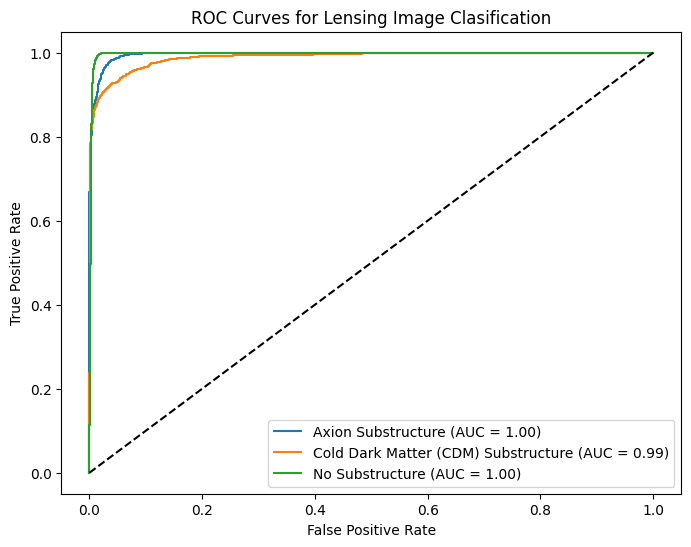

In [19]:
# PLOT ROC CURVES

def evaluate_and_plot_roc(model, val_dataloader, class_names, device="cuda"):
    """Loads the best saved model and plots ROC curves for all three classes."""
    model.load_state_dict(torch.load("best_class_model.pth"))
    model.to(device)
    model.eval()
    
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)[0]
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Lensing Image Clasification')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
class_names = ['Axion Substructure', 'Cold Dark Matter (CDM) Substructure', 'No Substructure']
evaluate_and_plot_roc(model, val_loader, class_names, device="cuda")


# Super-Resolution Model  

## Overview  

The Super-Resolution model is a composite architecture that integrates:  

1. **MAE Encoder:** Extracts feature representations from the input image.  
2. **Token-to-Convolution Neck:** Bridges the gap between transformer-based token representations and convolutional processing.  
3. **Super-Resolution Head:** Upscales the image while preserving spatial details and minimizing artifacts.  

## Components  

### 1. Encoder  

- The encoder is identical to the one used in the Masked Autoencoder Classifier.  
- It is initialized with pretrained weights from the MAE model, ensuring rich feature extraction.  

### 2. Token-to-Convolution Neck  

- This module is inspired by the **Token-to-Convolution** neck used by NASA for fine-tuning the **Prithvi EO** model in segmentation tasks.  
  - [Reference: NASA’s Prithvi EO Model](https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M/tree/main)  
- The architecture has been modified to:  
  - Use smaller embedding sizes and patch dimensions.  
  - Scale up decoder outputs while preserving spatial integrity.  

### 3. Super-Resolution Head  

Designed from scratch, this component performs the following:  

1. **Transposed Convolutions:**  
   - Upscales the image to a resolution of **256x256** while reducing channel dimensions.  

2. **Resizing and Convolution:**  
   - The output is resized to **150x150** and passed through a same-size convolution layer.  

3. **Pixel Shuffle:**  
   - Reduces checkerboard artifacts, ensuring a smoother and more natural output.  

## Optimization Goals  

- The architecture was fine-tuned to **minimize checkerboard effects** and enhance visual clarity.  
- The model is optimized for high **Structural Similarity Index (SSIM)** and **Peak Signal-to-Noise Ratio (PSNR)**, ensuring high-quality super-resolution results.  


In [20]:
# THE SUPER RESOLUTION MODEL

class CombinedSuperResModel(nn.Module):
    def __init__(self, emb_size=512, decoder_emb_size=256, patch_size=16, num_head=16, 
                 encoder_num_layers=6, decoder_num_layers=4, in_channels=1, img_size=64):
        super().__init__()
        
        # Encoder (ViT-based)
        self.patch_embed = PatchEmbedding(emb_size=emb_size, in_channels=in_channels, img_size=img_size, patch_size=patch_size)
        self.encoder_transformer = nn.Sequential(*[Block(emb_size, num_head) for _ in range(encoder_num_layers)])
                
        # ConvTransformer Neck
        self.neck = ConvTransformerTokensToEmbeddingNeck(embed_dim=emb_size, output_embed_dim=512, Hp=4, Wp=4)
        
        # Super-resolution Head
        self.super_res_head = SuperResHead()
        
    def forward(self, img):
        # Encoder
        x = self.patch_embed(img)
        cls_token = x[:, :1, :]
        x = x[:, 1:, :]
        x = torch.cat((cls_token, x), dim=1)
        x = self.encoder_transformer(x)
        
        # ConvTransformer Neck
        x = self.neck(x)
        
        # Super-resolution Head
        x = self.super_res_head(x)
        
        return x

def _convTranspose2dOutput(
    input_size: int,
    stride: int,
    padding: int,
    dilation: int,
    kernel_size: int,
    output_padding: int,
):
    """
    Calculate the output size of a ConvTranspose2d.
    Taken from: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
    """
    return (
        (input_size - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )


class Norm2d(nn.Module):
    def __init__(self, embed_dim: int):
        super().__init__()
        self.ln = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = self.ln(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        return x

class ConvTransformerTokensToEmbeddingNeck(nn.Module):
    """
    Neck that transforms the token-based output of transformer into a single embedding suitable for processing with standard layers.
    Performs 4 ConvTranspose2d operations on the rearranged input with kernel_size=2 and stride=2
    """

    def __init__(
        self,
        embed_dim: int =512,
        output_embed_dim: int =512,
        # num_frames: int = 1,
        Hp: int = 4,
        Wp: int = 4,
        drop_cls_token: bool = True,
    ):
        """

        Args:
            embed_dim (int): Input embedding dimension
            output_embed_dim (int): Output embedding dimension
            Hp (int, optional): Height (in patches) of embedding to be upscaled. Defaults to 14.
            Wp (int, optional): Width (in patches) of embedding to be upscaled. Defaults to 14.
            drop_cls_token (bool, optional): Whether there is a cls_token, which should be dropped. This assumes the cls token is the first token. Defaults to True.
        """
        super().__init__()
        self.drop_cls_token = drop_cls_token
        self.Hp = Hp
        self.Wp = Wp
        self.H_out = Hp
        self.W_out = Wp
        # self.num_frames = num_frames

        kernel_size = 2
        stride = 2
        dilation = 1
        padding = 0
        output_padding = 0
        for _ in range(4):
            self.H_out = _convTranspose2dOutput(
                self.H_out, stride, padding, dilation, kernel_size, output_padding
            )
            self.W_out = _convTranspose2dOutput(
                self.W_out, stride, padding, dilation, kernel_size, output_padding
            )

        self.embed_dim = embed_dim
        self.output_embed_dim = output_embed_dim
        self.fpn1 = nn.Sequential(
            nn.ConvTranspose2d(
                self.embed_dim,
                self.output_embed_dim,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding,
                output_padding=output_padding,
            ),
            Norm2d(self.output_embed_dim),
            nn.GELU(),
            nn.ConvTranspose2d(
                self.output_embed_dim,
                self.output_embed_dim,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding,
                output_padding=output_padding,
            ),
        )
        self.fpn2 = nn.Sequential(
            nn.ConvTranspose2d(
                self.output_embed_dim,
                self.output_embed_dim,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding,
                output_padding=output_padding,
            ),
            Norm2d(self.output_embed_dim),
            nn.GELU(),
            nn.ConvTranspose2d(
                self.output_embed_dim,
                self.output_embed_dim,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding,
                output_padding=output_padding,
            ),
        )

    def forward(self, x):
        if self.drop_cls_token:
            x = x[:, 1:, :]
        x = x.permute(0, 2, 1).reshape(x.shape[0], -1, self.Hp, self.Wp)

        x = self.fpn1(x)
        x = self.fpn2(x)

        x = x.reshape((-1, self.output_embed_dim, self.H_out, self.W_out))

        return x

class SuperResHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(512, 256, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = F.interpolate(x, size=(150, 150), mode='bilinear', align_corners=True)
        x = self.output_conv(x)
        x = self.pixel_shuffle(x)
        return x

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x = torch.rand(1, 1, 64, 64).to(device)
    model = CombinedSuperResModel().to(device)
    model.load_state_dict(torch.load("best_class_model.pth"), strict= False)
    output = model(x)
    print(output.shape)  # Expected output: [1, 1, 64, 64]


torch.Size([1, 1, 150, 150])


<ipython-input-20-e094571f4549>:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_class_model.pth"), strict= False)


In [21]:
# DATASET TRANSFORMS AND DATALOADER FOR SUPER RESOLUTION

# Dataset Definition
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None, resize= None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.resize = resize
        self.files = sorted(os.listdir(lr_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        # Load numpy arrays
        lr_img = np.load(lr_path).astype(np.float32)  # (75, 75)
        hr_img = np.load(hr_path).astype(np.float32)  # (75, 75)

        # Convert to 3D tensor (1 channel for grayscale)
        lr_img = torch.from_numpy(lr_img)
        hr_img = torch.from_numpy(hr_img)

        # Apply transformations
        if self.transform:
            lr_img = self.resize(lr_img)
            lr_img, hr_img = self.transform(lr_img, hr_img)

        return lr_img, hr_img

class Transform:
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, img, target):
        # Randomly decide transformation parameters
        if torch.rand(1) < self.flip_prob:
            img = TF.hflip(img)
            target = TF.hflip(target)

        if torch.rand(1) < self.flip_prob:
            img = TF.vflip(img)
            target = TF.vflip(target)

        return img, target

# Transforms
transform = Transform()
resize = transforms.Compose([
    transforms.Resize((64, 64), antialias=True)
])

# Load Dataset
lr_dir = "/kaggle/working/Dataset/LR"
hr_dir = "/kaggle/working/Dataset/HR"

dataset = SuperResolutionDataset(lr_dir, hr_dir, transform=transform, resize=resize)
train_size = int(0.9 * len(dataset)) # 90:10 train test split
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


100%|██████████| 563/563 [01:30<00:00,  6.25it/s]


Epoch 1/15, Loss: 0.001737


100%|██████████| 1000/1000 [00:16<00:00, 61.20it/s]


New best model saved with SSIM: 0.9480
MSE: 0.000475, PSNR: 33.50, SSIM: 0.9480


100%|██████████| 563/563 [01:29<00:00,  6.26it/s]


Epoch 2/15, Loss: 0.000516


100%|██████████| 1000/1000 [00:16<00:00, 60.11it/s]


New best model saved with SSIM: 0.9565
MSE: 0.000278, PSNR: 35.82, SSIM: 0.9565


100%|██████████| 563/563 [01:32<00:00,  6.08it/s]


Epoch 3/15, Loss: 0.000504


100%|██████████| 1000/1000 [00:16<00:00, 61.15it/s]


New best model saved with SSIM: 0.9613
MSE: 0.000182, PSNR: 37.60, SSIM: 0.9613


100%|██████████| 563/563 [01:32<00:00,  6.08it/s]


Epoch 4/15, Loss: 0.000183


100%|██████████| 1000/1000 [00:16<00:00, 60.83it/s]


New best model saved with SSIM: 0.9635
MSE: 0.000143, PSNR: 38.57, SSIM: 0.9635


100%|██████████| 563/563 [01:32<00:00,  6.08it/s]

Epoch 5/15, Loss: 0.000148


Validation Loss: 0.000001


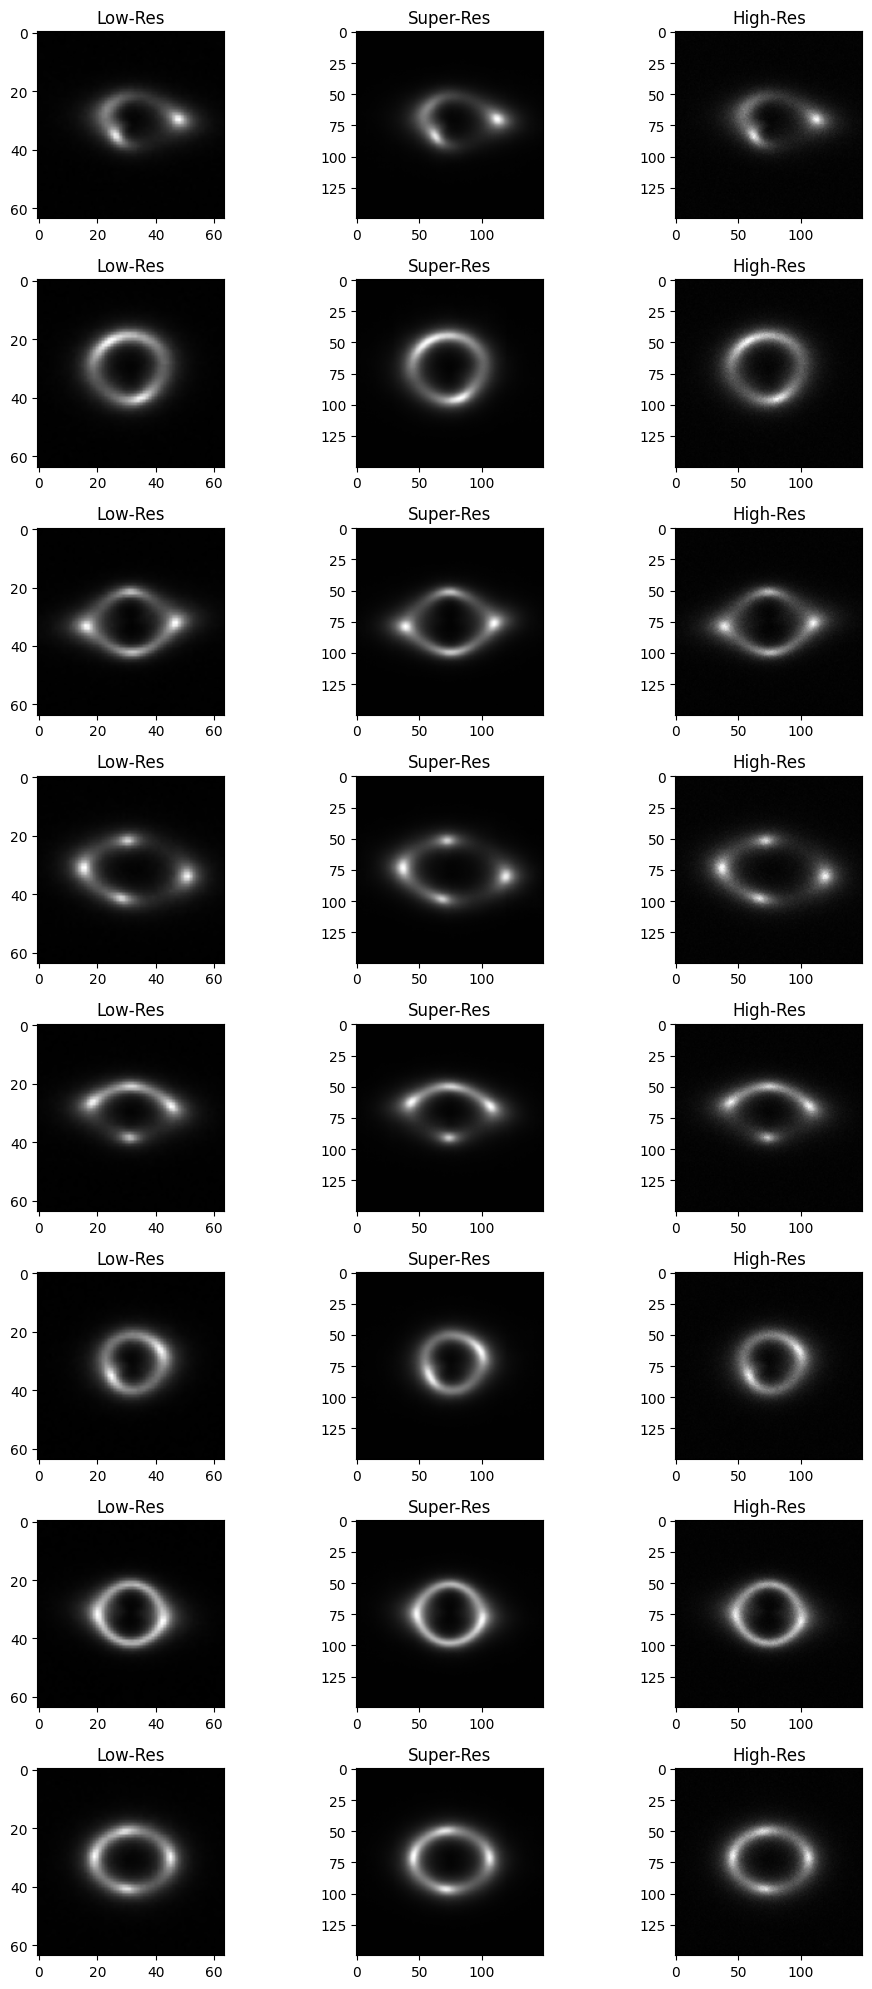

100%|██████████| 1000/1000 [00:16<00:00, 60.19it/s]


New best model saved with SSIM: 0.9660
MSE: 0.000120, PSNR: 39.29, SSIM: 0.9660


100%|██████████| 563/563 [01:32<00:00,  6.07it/s]


Epoch 6/15, Loss: 0.000135


100%|██████████| 1000/1000 [00:16<00:00, 61.40it/s]


New best model saved with SSIM: 0.9661
MSE: 0.000129, PSNR: 38.98, SSIM: 0.9661


100%|██████████| 563/563 [01:32<00:00,  6.09it/s]


Epoch 7/15, Loss: 0.000125


100%|██████████| 1000/1000 [00:16<00:00, 60.15it/s]


New best model saved with SSIM: 0.9665
MSE: 0.000121, PSNR: 39.29, SSIM: 0.9665


100%|██████████| 563/563 [01:32<00:00,  6.08it/s]


Epoch 8/15, Loss: 0.000126


100%|██████████| 1000/1000 [00:16<00:00, 60.47it/s]


New best model saved with SSIM: 0.9672
MSE: 0.000103, PSNR: 39.91, SSIM: 0.9672


100%|██████████| 563/563 [01:32<00:00,  6.08it/s]


Epoch 9/15, Loss: 0.000117


100%|██████████| 1000/1000 [00:16<00:00, 59.51it/s]


New best model saved with SSIM: 0.9673
MSE: 0.000102, PSNR: 39.99, SSIM: 0.9673


100%|██████████| 563/563 [01:32<00:00,  6.07it/s]

Epoch 10/15, Loss: 0.000120


Validation Loss: 0.000001


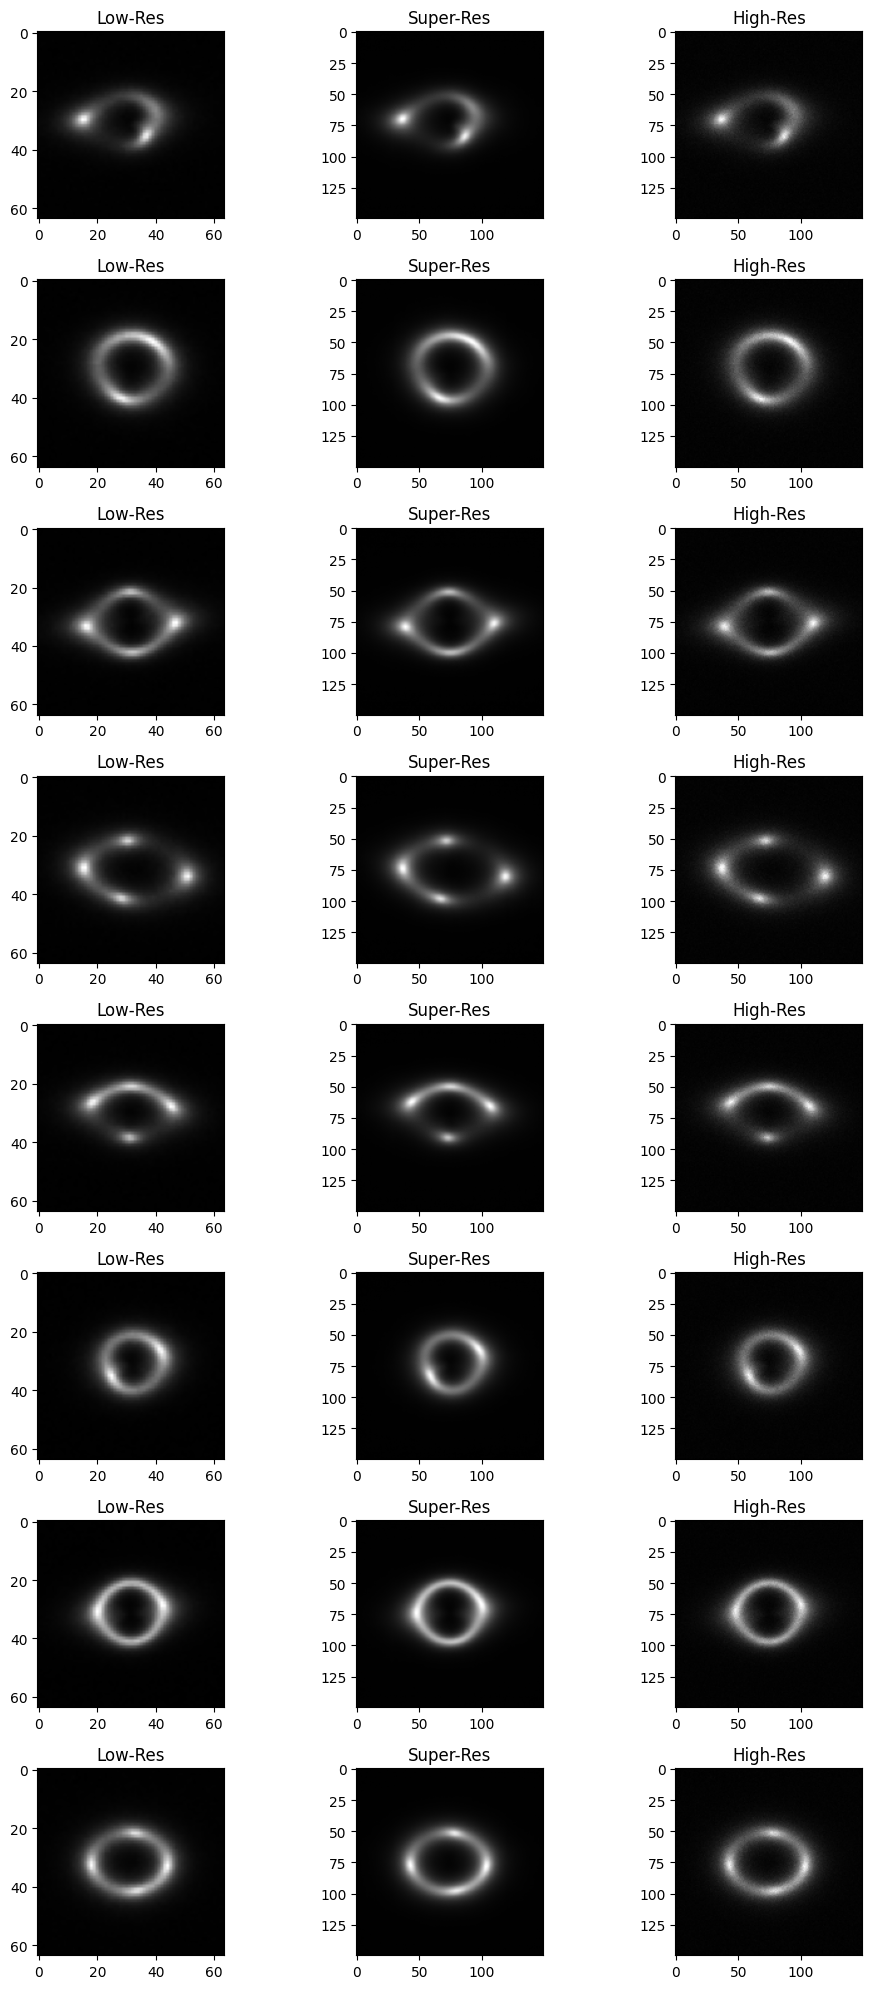

100%|██████████| 1000/1000 [00:16<00:00, 60.25it/s]


New best model saved with SSIM: 0.9674
MSE: 0.000118, PSNR: 39.36, SSIM: 0.9674


100%|██████████| 563/563 [01:32<00:00,  6.09it/s]


Epoch 11/15, Loss: 0.000113


100%|██████████| 1000/1000 [00:16<00:00, 60.40it/s]


New best model saved with SSIM: 0.9676
MSE: 0.000112, PSNR: 39.57, SSIM: 0.9676


100%|██████████| 563/563 [01:32<00:00,  6.10it/s]


Epoch 12/15, Loss: 0.000115


100%|██████████| 1000/1000 [00:16<00:00, 59.73it/s]


New best model saved with SSIM: 0.9678
MSE: 0.000098, PSNR: 40.16, SSIM: 0.9678


100%|██████████| 563/563 [01:32<00:00,  6.07it/s]


Epoch 13/15, Loss: 0.000110


100%|██████████| 1000/1000 [00:16<00:00, 59.99it/s]


New best model saved with SSIM: 0.9676
MSE: 0.000103, PSNR: 39.91, SSIM: 0.9676


100%|██████████| 563/563 [01:32<00:00,  6.09it/s]


Epoch 14/15, Loss: 0.000111


100%|██████████| 1000/1000 [00:16<00:00, 61.21it/s]


New best model saved with SSIM: 0.9680
MSE: 0.000096, PSNR: 40.25, SSIM: 0.9680


100%|██████████| 563/563 [01:32<00:00,  6.08it/s]

Epoch 15/15, Loss: 0.000106


Validation Loss: 0.000001


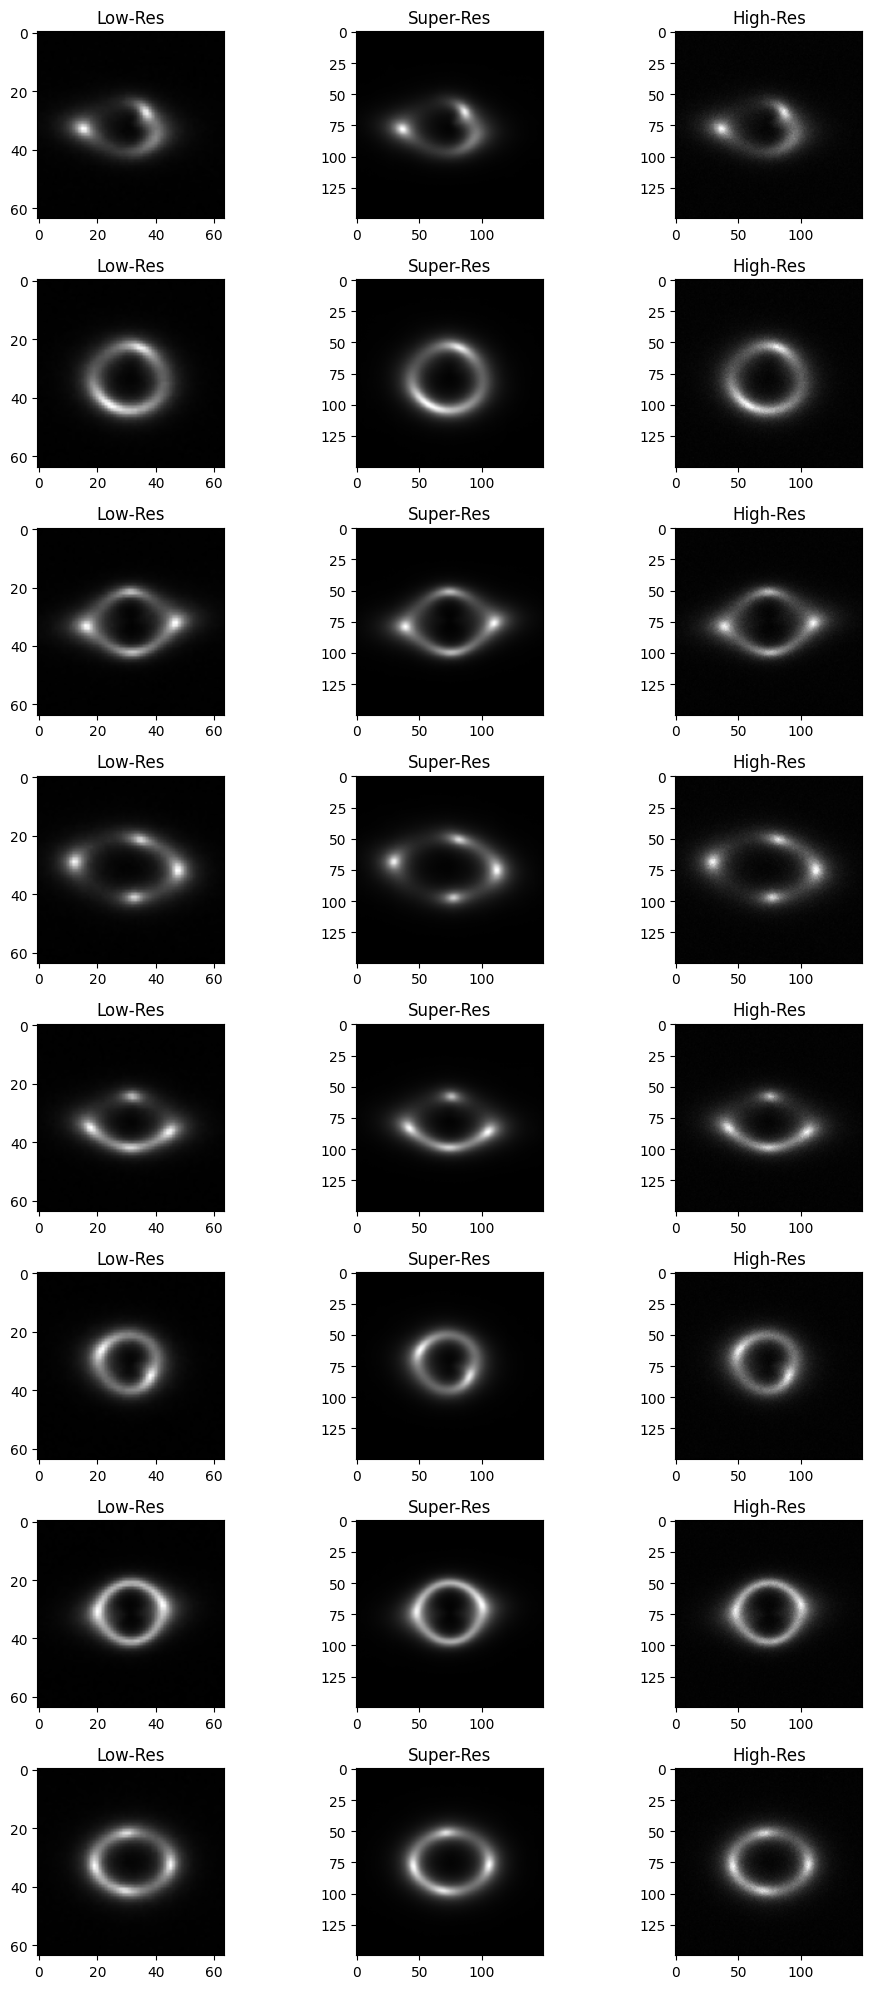

100%|██████████| 1000/1000 [00:16<00:00, 61.44it/s]


New best model saved with SSIM: 0.9673
MSE: 0.000103, PSNR: 39.93, SSIM: 0.9673


In [22]:
# TRAINING AND METRICS FOR SUPER RESOLUTION

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, test_loader, device="cuda"):
    model.eval()
    mse_total, psnr_total, ssim_total = 0, 0, 0
    best_ssim = 0.0
    best_model_path = "best_model_super_res.pth"
    
    all_ssim_scores = []
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(test_loader):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs).cpu().numpy().squeeze()
            hr_imgs = hr_imgs.cpu().numpy().squeeze()
            
            # Compute Metrics
            mse = np.mean((sr_imgs - hr_imgs) ** 2)
            psnr = 20 * np.log10(hr_imgs.max() / np.sqrt(mse))
            ssim_score = ssim(sr_imgs, hr_imgs, data_range=hr_imgs.max() - hr_imgs.min())
            
            mse_total += mse
            psnr_total += psnr
            ssim_total += ssim_score
            all_ssim_scores.append(ssim_score)
    
    avg_ssim = ssim_total / len(test_loader)
    
    # Save model if the new SSIM is the best so far
    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with SSIM: {best_ssim:.4f}")
    
    print(f"MSE: {mse_total / len(test_loader):.6f}, "
          f"PSNR: {psnr_total / len(test_loader):.2f}, "
          f"SSIM: {avg_ssim:.4f}")


# Validation Function
def validate(model, test_loader):
    model.eval()
    total_val_loss = 0
    images_lr, images_hr, images_sr = [], [], []  # Store images for visualization

    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            total_val_loss += loss.item()

            # Convert to numpy for visualization
            images_lr.append(lr_imgs.cpu().numpy().squeeze())
            images_hr.append(hr_imgs.cpu().numpy().squeeze())
            images_sr.append(sr_imgs.cpu().numpy().squeeze())

            if len(images_lr) >= 8:  # Stop after storing 8 images
                break

    print(f"Validation Loss: {total_val_loss / len(test_loader):.6f}")

    # Display 8 sample images
    fig, axes = plt.subplots(8, 3, figsize=(10, 20))
    for i in range(8):
        axes[i, 0].imshow(images_lr[i], cmap="gray")
        axes[i, 0].set_title("Low-Res")
        axes[i, 1].imshow(images_sr[i], cmap="gray")
        axes[i, 1].set_title("Super-Res")
        axes[i, 2].imshow(images_hr[i], cmap="gray")
        axes[i, 2].set_title("High-Res")

    plt.tight_layout()
    plt.show()

# Training Loop
epochs = 15
   
# Freeze encoder_transformer initially
for param in model.encoder_transformer.parameters():
    param.requires_grad = False
    
for epoch in range(epochs):
    if epoch == 2:  # Unfreeze after 2 epochs
        for param in model.encoder_transformer.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Reinitialize optimizer
        
    model.train()
    total_loss = 0

    for lr_imgs, hr_imgs in tqdm(train_loader):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        
        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")
    if (epoch + 1) % 5 == 0:
        validate(model, test_loader)
    
    evaluate(model, test_loader)